# Libraries & Custom functions

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Build a custom CNN composed of 5 convolutional layers with ReLU activation between all the five layers and a fully-connected output layer.

class FashionMNIST_ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 0)
        self.conv3 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 0)
        self.conv4 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0)
        self.conv5 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 0)
        self.fc = torch.nn.Linear(128 * 7 * 7, 10)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x
    

def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = [], [], [], []

    # Create a plot with labeled axes
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        val_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)

            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        val_loss /= len(test_loader)
        val_accuracy = 100 * correct / total
        print(f'Validation Cross-Entropy Loss = {val_loss:.4f}')
        print(f'Validation Accuracy = {val_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        test_loss_hist.append(val_loss)
        test_acc_hist.append(val_accuracy)


    # Plot the training loss over epochs
    epochs = range(2, len(train_loss_hist) + 1)

    plt.plot(epochs, train_loss_hist[1:], label='Training Loss')
    plt.plot(epochs, test_loss_hist[1:], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Evolution')
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")
    print()
    print(f"Cross-Entropy on validation set: {test_loss_hist[-1]:.4f}")
    print(f"Accuracy on validation set:      {test_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist

# Exercise 1

## Exercise 1 (C)

In [3]:
# Define data preprocessing and loading / Define a transform to convert to images to tensor and normalize
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.FashionMNIST(root = './data', train = False, transform = transform, download = True)

batch_size = 2048

TrainLoader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
TestLoader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

### Exercise 1 (C) i)

In [4]:
# Initialize the network, loss function, and optimizer
device = set_device()
ConvNet = FashionMNIST_ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet.parameters(), lr = 0.01)

Device: mps


Epoch 1/64
======== Training phase ========


Loss = 0.6737  |  Accuracy = 52.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Training Cross-Entropy Loss = 1.2557
Training Accuracy = 52.73%
======== Validation phase ========


Loss = 0.7088  |  Accuracy = 73.05% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Validation Cross-Entropy Loss = 0.7129
Validation Accuracy = 73.05%

Epoch 2/64
======== Training phase ========


Loss = 0.4692  |  Accuracy = 78.04% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


Training Cross-Entropy Loss = 0.5711
Training Accuracy = 78.04%
======== Validation phase ========


Loss = 0.5162  |  Accuracy = 79.54% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.49it/s]


Validation Cross-Entropy Loss = 0.5231
Validation Accuracy = 79.54%

Epoch 3/64
======== Training phase ========


Loss = 0.4300  |  Accuracy = 83.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  6.88it/s]


Training Cross-Entropy Loss = 0.4470
Training Accuracy = 83.19%
======== Validation phase ========


Loss = 0.4422  |  Accuracy = 83.18% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.41it/s]


Validation Cross-Entropy Loss = 0.4447
Validation Accuracy = 83.18%

Epoch 4/64
======== Training phase ========


Loss = 0.3356  |  Accuracy = 85.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.04it/s]


Training Cross-Entropy Loss = 0.3820
Training Accuracy = 85.75%
======== Validation phase ========


Loss = 0.3809  |  Accuracy = 85.68% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.35it/s]


Validation Cross-Entropy Loss = 0.3848
Validation Accuracy = 85.68%

Epoch 5/64
======== Training phase ========


Loss = 0.2822  |  Accuracy = 87.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.16it/s]


Training Cross-Entropy Loss = 0.3368
Training Accuracy = 87.62%
======== Validation phase ========


Loss = 0.3322  |  Accuracy = 87.10% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Validation Cross-Entropy Loss = 0.3477
Validation Accuracy = 87.10%

Epoch 6/64
======== Training phase ========


Loss = 0.2967  |  Accuracy = 88.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


Training Cross-Entropy Loss = 0.3091
Training Accuracy = 88.68%
======== Validation phase ========


Loss = 0.3083  |  Accuracy = 87.91% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.59it/s]


Validation Cross-Entropy Loss = 0.3289
Validation Accuracy = 87.91%

Epoch 7/64
======== Training phase ========


Loss = 0.2890  |  Accuracy = 89.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.14it/s]


Training Cross-Entropy Loss = 0.2885
Training Accuracy = 89.41%
======== Validation phase ========


Loss = 0.3124  |  Accuracy = 88.16% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]


Validation Cross-Entropy Loss = 0.3216
Validation Accuracy = 88.16%

Epoch 8/64
======== Training phase ========


Loss = 0.2677  |  Accuracy = 90.12% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  6.94it/s]


Training Cross-Entropy Loss = 0.2696
Training Accuracy = 90.12%
======== Validation phase ========


Loss = 0.2874  |  Accuracy = 88.89% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]


Validation Cross-Entropy Loss = 0.3060
Validation Accuracy = 88.89%

Epoch 9/64
======== Training phase ========


Loss = 0.2513  |  Accuracy = 90.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.19it/s]


Training Cross-Entropy Loss = 0.2552
Training Accuracy = 90.64%
======== Validation phase ========


Loss = 0.2946  |  Accuracy = 89.16% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]


Validation Cross-Entropy Loss = 0.3002
Validation Accuracy = 89.16%

Epoch 10/64
======== Training phase ========


Loss = 0.2124  |  Accuracy = 91.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.21it/s]


Training Cross-Entropy Loss = 0.2424
Training Accuracy = 91.11%
======== Validation phase ========


Loss = 0.2844  |  Accuracy = 89.64% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]


Validation Cross-Entropy Loss = 0.2915
Validation Accuracy = 89.64%

Epoch 11/64
======== Training phase ========


Loss = 0.2715  |  Accuracy = 91.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.08it/s]


Training Cross-Entropy Loss = 0.2309
Training Accuracy = 91.58%
======== Validation phase ========


Loss = 0.2659  |  Accuracy = 89.71% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]


Validation Cross-Entropy Loss = 0.2834
Validation Accuracy = 89.71%

Epoch 12/64
======== Training phase ========


Loss = 0.2207  |  Accuracy = 91.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.20it/s]


Training Cross-Entropy Loss = 0.2218
Training Accuracy = 91.89%
======== Validation phase ========


Loss = 0.2761  |  Accuracy = 88.77% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.23it/s]


Validation Cross-Entropy Loss = 0.2941
Validation Accuracy = 88.77%

Epoch 13/64
======== Training phase ========


Loss = 0.2160  |  Accuracy = 91.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


Training Cross-Entropy Loss = 0.2182
Training Accuracy = 91.92%
======== Validation phase ========


Loss = 0.2544  |  Accuracy = 90.26% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]


Validation Cross-Entropy Loss = 0.2749
Validation Accuracy = 90.26%

Epoch 14/64
======== Training phase ========


Loss = 0.1959  |  Accuracy = 92.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.01it/s]


Training Cross-Entropy Loss = 0.2038
Training Accuracy = 92.38%
======== Validation phase ========


Loss = 0.2587  |  Accuracy = 90.20% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.67it/s]


Validation Cross-Entropy Loss = 0.2766
Validation Accuracy = 90.20%

Epoch 15/64
======== Training phase ========


Loss = 0.1978  |  Accuracy = 92.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.32it/s]


Training Cross-Entropy Loss = 0.1994
Training Accuracy = 92.56%
======== Validation phase ========


Loss = 0.2612  |  Accuracy = 90.19% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.80it/s]


Validation Cross-Entropy Loss = 0.2791
Validation Accuracy = 90.19%

Epoch 16/64
======== Training phase ========


Loss = 0.2389  |  Accuracy = 92.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.29it/s]


Training Cross-Entropy Loss = 0.1983
Training Accuracy = 92.66%
======== Validation phase ========


Loss = 0.2600  |  Accuracy = 89.82% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.72it/s]


Validation Cross-Entropy Loss = 0.2862
Validation Accuracy = 89.82%

Epoch 17/64
======== Training phase ========


Loss = 0.2119  |  Accuracy = 93.37% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  6.99it/s]


Training Cross-Entropy Loss = 0.1808
Training Accuracy = 93.37%
======== Validation phase ========


Loss = 0.2508  |  Accuracy = 90.43% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.23it/s]


Validation Cross-Entropy Loss = 0.2741
Validation Accuracy = 90.43%

Epoch 18/64
======== Training phase ========


Loss = 0.1509  |  Accuracy = 93.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.26it/s]


Training Cross-Entropy Loss = 0.1735
Training Accuracy = 93.61%
======== Validation phase ========


Loss = 0.3099  |  Accuracy = 88.69% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]


Validation Cross-Entropy Loss = 0.3281
Validation Accuracy = 88.69%

Epoch 19/64
======== Training phase ========


Loss = 0.1536  |  Accuracy = 93.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


Training Cross-Entropy Loss = 0.1794
Training Accuracy = 93.34%
======== Validation phase ========


Loss = 0.2883  |  Accuracy = 89.89% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.87it/s]


Validation Cross-Entropy Loss = 0.3118
Validation Accuracy = 89.89%

Epoch 20/64
======== Training phase ========


Loss = 0.1362  |  Accuracy = 93.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


Training Cross-Entropy Loss = 0.1675
Training Accuracy = 93.76%
======== Validation phase ========


Loss = 0.2992  |  Accuracy = 89.74% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.79it/s]


Validation Cross-Entropy Loss = 0.3134
Validation Accuracy = 89.74%

Epoch 21/64
======== Training phase ========


Loss = 0.1915  |  Accuracy = 94.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.25it/s]


Training Cross-Entropy Loss = 0.1588
Training Accuracy = 94.23%
======== Validation phase ========


Loss = 0.2812  |  Accuracy = 90.03% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.67it/s]


Validation Cross-Entropy Loss = 0.3031
Validation Accuracy = 90.03%

Epoch 22/64
======== Training phase ========


Loss = 0.1398  |  Accuracy = 94.32% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.36it/s]


Training Cross-Entropy Loss = 0.1534
Training Accuracy = 94.32%
======== Validation phase ========


Loss = 0.2721  |  Accuracy = 90.36% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.78it/s]


Validation Cross-Entropy Loss = 0.3063
Validation Accuracy = 90.36%

Epoch 23/64
======== Training phase ========


Loss = 0.1386  |  Accuracy = 94.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.15it/s]


Training Cross-Entropy Loss = 0.1495
Training Accuracy = 94.48%
======== Validation phase ========


Loss = 0.3024  |  Accuracy = 89.45% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.59it/s]


Validation Cross-Entropy Loss = 0.3067
Validation Accuracy = 89.45%

Epoch 24/64
======== Training phase ========


Loss = 0.1357  |  Accuracy = 94.91% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.37it/s]


Training Cross-Entropy Loss = 0.1388
Training Accuracy = 94.91%
======== Validation phase ========


Loss = 0.2764  |  Accuracy = 89.99% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.81it/s]


Validation Cross-Entropy Loss = 0.3046
Validation Accuracy = 89.99%

Epoch 25/64
======== Training phase ========


Loss = 0.1531  |  Accuracy = 95.12% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


Training Cross-Entropy Loss = 0.1331
Training Accuracy = 95.12%
======== Validation phase ========


Loss = 0.2934  |  Accuracy = 90.29% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.56it/s]


Validation Cross-Entropy Loss = 0.3070
Validation Accuracy = 90.29%

Epoch 26/64
======== Training phase ========


Loss = 0.1292  |  Accuracy = 95.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.09it/s]


Training Cross-Entropy Loss = 0.1312
Training Accuracy = 95.14%
======== Validation phase ========


Loss = 0.2988  |  Accuracy = 90.23% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.53it/s]


Validation Cross-Entropy Loss = 0.3102
Validation Accuracy = 90.23%

Epoch 27/64
======== Training phase ========


Loss = 0.1233  |  Accuracy = 95.35% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


Training Cross-Entropy Loss = 0.1266
Training Accuracy = 95.35%
======== Validation phase ========


Loss = 0.3239  |  Accuracy = 90.06% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.71it/s]


Validation Cross-Entropy Loss = 0.3313
Validation Accuracy = 90.06%

Epoch 28/64
======== Training phase ========


Loss = 0.1524  |  Accuracy = 95.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.24it/s]


Training Cross-Entropy Loss = 0.1262
Training Accuracy = 95.38%
======== Validation phase ========


Loss = 0.3245  |  Accuracy = 90.22% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Validation Cross-Entropy Loss = 0.3516
Validation Accuracy = 90.22%

Epoch 29/64
======== Training phase ========


Loss = 0.1085  |  Accuracy = 95.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.20it/s]


Training Cross-Entropy Loss = 0.1266
Training Accuracy = 95.26%
======== Validation phase ========


Loss = 0.3359  |  Accuracy = 89.79% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.65it/s]


Validation Cross-Entropy Loss = 0.3596
Validation Accuracy = 89.79%

Epoch 30/64
======== Training phase ========


Loss = 0.1451  |  Accuracy = 95.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.09it/s]


Training Cross-Entropy Loss = 0.1191
Training Accuracy = 95.71%
======== Validation phase ========


Loss = 0.3588  |  Accuracy = 88.68% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]


Validation Cross-Entropy Loss = 0.3825
Validation Accuracy = 88.68%

Epoch 31/64
======== Training phase ========


Loss = 0.1465  |  Accuracy = 95.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.28it/s]


Training Cross-Entropy Loss = 0.1158
Training Accuracy = 95.73%
======== Validation phase ========


Loss = 0.3650  |  Accuracy = 89.39% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  8.28it/s]


Validation Cross-Entropy Loss = 0.3721
Validation Accuracy = 89.39%

Epoch 32/64
======== Training phase ========


Loss = 0.1098  |  Accuracy = 95.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.32it/s]


Training Cross-Entropy Loss = 0.1180
Training Accuracy = 95.56%
======== Validation phase ========


Loss = 0.4010  |  Accuracy = 88.82% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]


Validation Cross-Entropy Loss = 0.3949
Validation Accuracy = 88.82%

Epoch 33/64
======== Training phase ========


Loss = 0.1199  |  Accuracy = 95.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Training Cross-Entropy Loss = 0.1147
Training Accuracy = 95.77%
======== Validation phase ========


Loss = 0.3794  |  Accuracy = 88.95% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]


Validation Cross-Entropy Loss = 0.3890
Validation Accuracy = 88.95%

Epoch 34/64
======== Training phase ========


Loss = 0.1126  |  Accuracy = 96.13% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.14it/s]


Training Cross-Entropy Loss = 0.1043
Training Accuracy = 96.13%
======== Validation phase ========


Loss = 0.3711  |  Accuracy = 89.63% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.67it/s]


Validation Cross-Entropy Loss = 0.3946
Validation Accuracy = 89.63%

Epoch 35/64
======== Training phase ========


Loss = 0.0871  |  Accuracy = 96.23% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Training Cross-Entropy Loss = 0.1003
Training Accuracy = 96.23%
======== Validation phase ========


Loss = 0.4001  |  Accuracy = 89.22% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.69it/s]


Validation Cross-Entropy Loss = 0.4101
Validation Accuracy = 89.22%

Epoch 36/64
======== Training phase ========


Loss = 0.0864  |  Accuracy = 96.06% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


Training Cross-Entropy Loss = 0.1040
Training Accuracy = 96.06%
======== Validation phase ========


Loss = 0.3955  |  Accuracy = 89.86% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]


Validation Cross-Entropy Loss = 0.3973
Validation Accuracy = 89.86%

Epoch 37/64
======== Training phase ========


Loss = 0.0995  |  Accuracy = 96.67% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.16it/s]


Training Cross-Entropy Loss = 0.0907
Training Accuracy = 96.67%
======== Validation phase ========


Loss = 0.4386  |  Accuracy = 89.46% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.75it/s]


Validation Cross-Entropy Loss = 0.4367
Validation Accuracy = 89.46%

Epoch 38/64
======== Training phase ========


Loss = 0.1363  |  Accuracy = 96.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


Training Cross-Entropy Loss = 0.0987
Training Accuracy = 96.36%
======== Validation phase ========


Loss = 0.4521  |  Accuracy = 89.57% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


Validation Cross-Entropy Loss = 0.4440
Validation Accuracy = 89.57%

Epoch 39/64
======== Training phase ========


Loss = 0.1018  |  Accuracy = 96.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.37it/s]


Training Cross-Entropy Loss = 0.0937
Training Accuracy = 96.48%
======== Validation phase ========


Loss = 0.4339  |  Accuracy = 89.58% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


Validation Cross-Entropy Loss = 0.4315
Validation Accuracy = 89.58%

Epoch 40/64
======== Training phase ========


Loss = 0.0932  |  Accuracy = 96.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


Training Cross-Entropy Loss = 0.0890
Training Accuracy = 96.60%
======== Validation phase ========


Loss = 0.4773  |  Accuracy = 88.91% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]


Validation Cross-Entropy Loss = 0.4696
Validation Accuracy = 88.91%

Epoch 41/64
======== Training phase ========


Loss = 0.1569  |  Accuracy = 96.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.34it/s]


Training Cross-Entropy Loss = 0.0923
Training Accuracy = 96.60%
======== Validation phase ========


Loss = 0.4165  |  Accuracy = 89.67% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.65it/s]


Validation Cross-Entropy Loss = 0.4272
Validation Accuracy = 89.67%

Epoch 42/64
======== Training phase ========


Loss = 0.1386  |  Accuracy = 96.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Training Cross-Entropy Loss = 0.0972
Training Accuracy = 96.31%
======== Validation phase ========


Loss = 0.4842  |  Accuracy = 89.19% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]


Validation Cross-Entropy Loss = 0.4763
Validation Accuracy = 89.19%

Epoch 43/64
======== Training phase ========


Loss = 0.1056  |  Accuracy = 96.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.21it/s]


Training Cross-Entropy Loss = 0.0930
Training Accuracy = 96.47%
======== Validation phase ========


Loss = 0.4735  |  Accuracy = 89.67% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.77it/s]


Validation Cross-Entropy Loss = 0.4794
Validation Accuracy = 89.67%

Epoch 44/64
======== Training phase ========


Loss = 0.0589  |  Accuracy = 96.69% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.44it/s]


Training Cross-Entropy Loss = 0.0887
Training Accuracy = 96.69%
======== Validation phase ========


Loss = 0.4637  |  Accuracy = 89.42% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.68it/s]


Validation Cross-Entropy Loss = 0.4857
Validation Accuracy = 89.42%

Epoch 45/64
======== Training phase ========


Loss = 0.0652  |  Accuracy = 96.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.34it/s]


Training Cross-Entropy Loss = 0.0835
Training Accuracy = 96.82%
======== Validation phase ========


Loss = 0.4601  |  Accuracy = 89.55% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]


Validation Cross-Entropy Loss = 0.4978
Validation Accuracy = 89.55%

Epoch 46/64
======== Training phase ========


Loss = 0.1069  |  Accuracy = 97.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.18it/s]


Training Cross-Entropy Loss = 0.0765
Training Accuracy = 97.11%
======== Validation phase ========


Loss = 0.5034  |  Accuracy = 89.34% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.81it/s]


Validation Cross-Entropy Loss = 0.5195
Validation Accuracy = 89.34%

Epoch 47/64
======== Training phase ========


Loss = 0.0978  |  Accuracy = 97.04% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Training Cross-Entropy Loss = 0.0781
Training Accuracy = 97.04%
======== Validation phase ========


Loss = 0.5075  |  Accuracy = 89.44% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]


Validation Cross-Entropy Loss = 0.5240
Validation Accuracy = 89.44%

Epoch 48/64
======== Training phase ========


Loss = 0.1019  |  Accuracy = 96.51% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


Training Cross-Entropy Loss = 0.0935
Training Accuracy = 96.51%
======== Validation phase ========


Loss = 0.4944  |  Accuracy = 89.17% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.75it/s]


Validation Cross-Entropy Loss = 0.5164
Validation Accuracy = 89.17%

Epoch 49/64
======== Training phase ========


Loss = 0.0638  |  Accuracy = 97.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.14it/s]


Training Cross-Entropy Loss = 0.0731
Training Accuracy = 97.19%
======== Validation phase ========


Loss = 0.5341  |  Accuracy = 89.62% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.61it/s]


Validation Cross-Entropy Loss = 0.5547
Validation Accuracy = 89.62%

Epoch 50/64
======== Training phase ========


Loss = 0.0732  |  Accuracy = 97.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Training Cross-Entropy Loss = 0.0664
Training Accuracy = 97.56%
======== Validation phase ========


Loss = 0.5622  |  Accuracy = 89.51% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.77it/s]


Validation Cross-Entropy Loss = 0.5532
Validation Accuracy = 89.51%

Epoch 51/64
======== Training phase ========


Loss = 0.0568  |  Accuracy = 97.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.33it/s]


Training Cross-Entropy Loss = 0.0647
Training Accuracy = 97.55%
======== Validation phase ========


Loss = 0.5249  |  Accuracy = 89.46% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.78it/s]


Validation Cross-Entropy Loss = 0.5472
Validation Accuracy = 89.46%

Epoch 52/64
======== Training phase ========


Loss = 0.0571  |  Accuracy = 97.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.11it/s]


Training Cross-Entropy Loss = 0.0699
Training Accuracy = 97.38%
======== Validation phase ========


Loss = 0.5652  |  Accuracy = 89.43% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.69it/s]


Validation Cross-Entropy Loss = 0.5679
Validation Accuracy = 89.43%

Epoch 53/64
======== Training phase ========


Loss = 0.0404  |  Accuracy = 97.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.26it/s]


Training Cross-Entropy Loss = 0.0632
Training Accuracy = 97.64%
======== Validation phase ========


Loss = 0.6152  |  Accuracy = 89.60% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.66it/s]


Validation Cross-Entropy Loss = 0.6127
Validation Accuracy = 89.60%

Epoch 54/64
======== Training phase ========


Loss = 0.0812  |  Accuracy = 97.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.26it/s]


Training Cross-Entropy Loss = 0.0728
Training Accuracy = 97.25%
======== Validation phase ========


Loss = 0.6268  |  Accuracy = 88.36% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


Validation Cross-Entropy Loss = 0.6163
Validation Accuracy = 88.36%

Epoch 55/64
======== Training phase ========


Loss = 0.1150  |  Accuracy = 97.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.28it/s]


Training Cross-Entropy Loss = 0.0822
Training Accuracy = 97.03%
======== Validation phase ========


Loss = 0.5552  |  Accuracy = 89.50% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.69it/s]


Validation Cross-Entropy Loss = 0.5609
Validation Accuracy = 89.50%

Epoch 56/64
======== Training phase ========


Loss = 0.0546  |  Accuracy = 96.98% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.26it/s]


Training Cross-Entropy Loss = 0.0809
Training Accuracy = 96.98%
======== Validation phase ========


Loss = 0.5160  |  Accuracy = 89.42% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]


Validation Cross-Entropy Loss = 0.5457
Validation Accuracy = 89.42%

Epoch 57/64
======== Training phase ========


Loss = 0.0924  |  Accuracy = 97.37% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.24it/s]


Training Cross-Entropy Loss = 0.0701
Training Accuracy = 97.37%
======== Validation phase ========


Loss = 0.5806  |  Accuracy = 88.58% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]


Validation Cross-Entropy Loss = 0.5967
Validation Accuracy = 88.58%

Epoch 58/64
======== Training phase ========


Loss = 0.0714  |  Accuracy = 96.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.26it/s]


Training Cross-Entropy Loss = 0.0945
Training Accuracy = 96.54%
======== Validation phase ========


Loss = 0.5618  |  Accuracy = 89.27% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.69it/s]


Validation Cross-Entropy Loss = 0.6161
Validation Accuracy = 89.27%

Epoch 59/64
======== Training phase ========


Loss = 0.0756  |  Accuracy = 96.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.25it/s]


Training Cross-Entropy Loss = 0.0840
Training Accuracy = 96.87%
======== Validation phase ========


Loss = 0.5744  |  Accuracy = 88.71% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]


Validation Cross-Entropy Loss = 0.5780
Validation Accuracy = 88.71%

Epoch 60/64
======== Training phase ========


Loss = 0.0784  |  Accuracy = 97.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.28it/s]


Training Cross-Entropy Loss = 0.0635
Training Accuracy = 97.64%
======== Validation phase ========


Loss = 0.6177  |  Accuracy = 89.00% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  8.20it/s]


Validation Cross-Entropy Loss = 0.5977
Validation Accuracy = 89.00%

Epoch 61/64
======== Training phase ========


Loss = 0.0603  |  Accuracy = 97.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.27it/s]


Training Cross-Entropy Loss = 0.0567
Training Accuracy = 97.92%
======== Validation phase ========


Loss = 0.6402  |  Accuracy = 89.60% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


Validation Cross-Entropy Loss = 0.6966
Validation Accuracy = 89.60%

Epoch 62/64
======== Training phase ========


Loss = 0.0417  |  Accuracy = 97.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.25it/s]


Training Cross-Entropy Loss = 0.0596
Training Accuracy = 97.75%
======== Validation phase ========


Loss = 0.6160  |  Accuracy = 89.08% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.67it/s]


Validation Cross-Entropy Loss = 0.6444
Validation Accuracy = 89.08%

Epoch 63/64
======== Training phase ========


Loss = 0.0520  |  Accuracy = 97.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


Training Cross-Entropy Loss = 0.0602
Training Accuracy = 97.77%
======== Validation phase ========


Loss = 0.6838  |  Accuracy = 89.49% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


Validation Cross-Entropy Loss = 0.6849
Validation Accuracy = 89.49%

Epoch 64/64
======== Training phase ========


Loss = 0.0613  |  Accuracy = 98.02% | Batch ID = 30 : 100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


Training Cross-Entropy Loss = 0.0545
Training Accuracy = 98.02%
======== Validation phase ========


Loss = 0.6874  |  Accuracy = 89.01% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  9.53it/s]


Validation Cross-Entropy Loss = 0.6962
Validation Accuracy = 89.01%



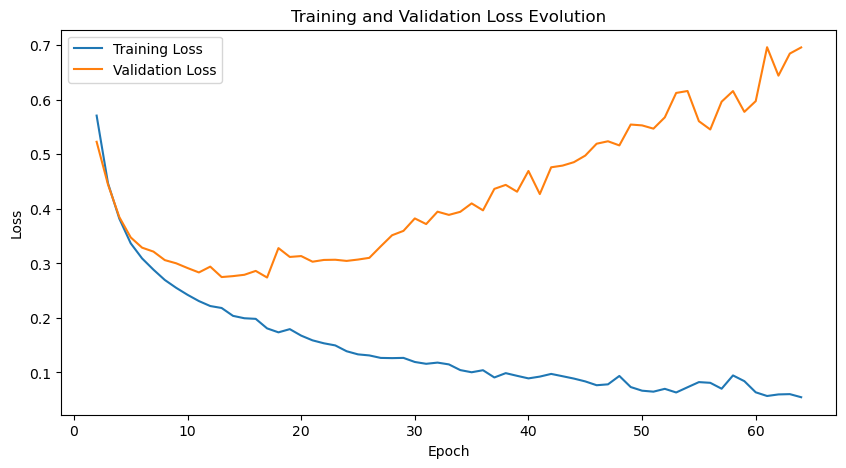

Cross-Entropy on training set:  0.0545
Accuracy on training set:       98.02%

Cross-Entropy on validation set: 0.6962
Accuracy on validation set:      89.01%


In [5]:
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ConvNet, TrainLoader, TestLoader, optimizer, criterion, epochs = 64, device = device)

### Exercise 1 (C) ii)

In [6]:
# Use a ResNet-18 without pre-trained weights
ResNet18 = resnet18(weights = None)

# Adapt the ResNet-18 to the FashionMNIST dataset
ResNet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
ResNet18.fc = torch.nn.Linear(ResNet18.fc.in_features, 10)

In [7]:
# Initialize the network, loss function, and optimizer
device = set_device()
ResNet18 = ResNet18.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18.parameters(), lr = 0.01)

Device: mps


Epoch 1/64
======== Training phase ========


Loss = 0.7157  |  Accuracy = 57.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Training Cross-Entropy Loss = 1.3350
Training Accuracy = 57.92%
======== Validation phase ========


Loss = 41.3411  |  Accuracy = 23.40% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Validation Cross-Entropy Loss = 41.1716
Validation Accuracy = 23.40%

Epoch 2/64
======== Training phase ========


Loss = 0.4171  |  Accuracy = 80.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.09it/s]


Training Cross-Entropy Loss = 0.5212
Training Accuracy = 80.25%
======== Validation phase ========


Loss = 0.4885  |  Accuracy = 81.45% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Validation Cross-Entropy Loss = 0.5008
Validation Accuracy = 81.45%

Epoch 3/64
======== Training phase ========


Loss = 0.3564  |  Accuracy = 83.99% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.4206
Training Accuracy = 83.99%
======== Validation phase ========


Loss = 0.4857  |  Accuracy = 81.31% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Validation Cross-Entropy Loss = 0.4951
Validation Accuracy = 81.31%

Epoch 4/64
======== Training phase ========


Loss = 0.3396  |  Accuracy = 86.81% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.09it/s]


Training Cross-Entropy Loss = 0.3526
Training Accuracy = 86.81%
======== Validation phase ========


Loss = 0.3524  |  Accuracy = 86.47% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Validation Cross-Entropy Loss = 0.3638
Validation Accuracy = 86.47%

Epoch 5/64
======== Training phase ========


Loss = 0.3313  |  Accuracy = 88.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.3124
Training Accuracy = 88.27%
======== Validation phase ========


Loss = 0.5629  |  Accuracy = 81.76% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


Validation Cross-Entropy Loss = 0.5715
Validation Accuracy = 81.76%

Epoch 6/64
======== Training phase ========


Loss = 0.2731  |  Accuracy = 89.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.2862
Training Accuracy = 89.27%
======== Validation phase ========


Loss = 0.5968  |  Accuracy = 80.71% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Validation Cross-Entropy Loss = 0.6089
Validation Accuracy = 80.71%

Epoch 7/64
======== Training phase ========


Loss = 0.2459  |  Accuracy = 89.98% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.2689
Training Accuracy = 89.98%
======== Validation phase ========


Loss = 0.3212  |  Accuracy = 87.94% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Validation Cross-Entropy Loss = 0.3235
Validation Accuracy = 87.94%

Epoch 8/64
======== Training phase ========


Loss = 0.2331  |  Accuracy = 90.88% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.2446
Training Accuracy = 90.88%
======== Validation phase ========


Loss = 0.3553  |  Accuracy = 86.83% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


Validation Cross-Entropy Loss = 0.3677
Validation Accuracy = 86.83%

Epoch 9/64
======== Training phase ========


Loss = 0.3383  |  Accuracy = 91.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.2277
Training Accuracy = 91.64%
======== Validation phase ========


Loss = 0.4671  |  Accuracy = 84.90% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Validation Cross-Entropy Loss = 0.4794
Validation Accuracy = 84.90%

Epoch 10/64
======== Training phase ========


Loss = 0.2538  |  Accuracy = 91.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.2239
Training Accuracy = 91.60%
======== Validation phase ========


Loss = 0.3184  |  Accuracy = 88.87% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


Validation Cross-Entropy Loss = 0.3184
Validation Accuracy = 88.87%

Epoch 11/64
======== Training phase ========


Loss = 0.2081  |  Accuracy = 92.50% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.2025
Training Accuracy = 92.50%
======== Validation phase ========


Loss = 0.3038  |  Accuracy = 88.59% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Validation Cross-Entropy Loss = 0.3112
Validation Accuracy = 88.59%

Epoch 12/64
======== Training phase ========


Loss = 0.1699  |  Accuracy = 92.69% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.1946
Training Accuracy = 92.69%
======== Validation phase ========


Loss = 0.3404  |  Accuracy = 87.47% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


Validation Cross-Entropy Loss = 0.3683
Validation Accuracy = 87.47%

Epoch 13/64
======== Training phase ========


Loss = 0.2355  |  Accuracy = 93.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.1811
Training Accuracy = 93.28%
======== Validation phase ========


Loss = 0.2945  |  Accuracy = 89.29% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Validation Cross-Entropy Loss = 0.3018
Validation Accuracy = 89.29%

Epoch 14/64
======== Training phase ========


Loss = 0.1802  |  Accuracy = 93.21% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.1789
Training Accuracy = 93.21%
======== Validation phase ========


Loss = 0.2735  |  Accuracy = 89.96% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Validation Cross-Entropy Loss = 0.2817
Validation Accuracy = 89.96%

Epoch 15/64
======== Training phase ========


Loss = 0.1556  |  Accuracy = 93.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.1650
Training Accuracy = 93.76%
======== Validation phase ========


Loss = 0.3278  |  Accuracy = 88.82% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


Validation Cross-Entropy Loss = 0.3402
Validation Accuracy = 88.82%

Epoch 16/64
======== Training phase ========


Loss = 0.2031  |  Accuracy = 94.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.1610
Training Accuracy = 94.03%
======== Validation phase ========


Loss = 0.3093  |  Accuracy = 89.57% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Validation Cross-Entropy Loss = 0.3185
Validation Accuracy = 89.57%

Epoch 17/64
======== Training phase ========


Loss = 0.1484  |  Accuracy = 94.33% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.1502
Training Accuracy = 94.33%
======== Validation phase ========


Loss = 0.3530  |  Accuracy = 89.05% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Validation Cross-Entropy Loss = 0.3605
Validation Accuracy = 89.05%

Epoch 18/64
======== Training phase ========


Loss = 0.1460  |  Accuracy = 94.67% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.1426
Training Accuracy = 94.67%
======== Validation phase ========


Loss = 0.3743  |  Accuracy = 87.69% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Validation Cross-Entropy Loss = 0.3907
Validation Accuracy = 87.69%

Epoch 19/64
======== Training phase ========


Loss = 0.1322  |  Accuracy = 94.85% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.1368
Training Accuracy = 94.85%
======== Validation phase ========


Loss = 0.3823  |  Accuracy = 87.18% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


Validation Cross-Entropy Loss = 0.4067
Validation Accuracy = 87.18%

Epoch 20/64
======== Training phase ========


Loss = 0.1507  |  Accuracy = 95.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.1277
Training Accuracy = 95.14%
======== Validation phase ========


Loss = 0.3973  |  Accuracy = 88.69% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Validation Cross-Entropy Loss = 0.3895
Validation Accuracy = 88.69%

Epoch 21/64
======== Training phase ========


Loss = 0.1388  |  Accuracy = 95.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.1199
Training Accuracy = 95.53%
======== Validation phase ========


Loss = 0.3873  |  Accuracy = 88.06% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Validation Cross-Entropy Loss = 0.4055
Validation Accuracy = 88.06%

Epoch 22/64
======== Training phase ========


Loss = 0.1542  |  Accuracy = 95.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.1223
Training Accuracy = 95.29%
======== Validation phase ========


Loss = 0.3406  |  Accuracy = 88.49% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Validation Cross-Entropy Loss = 0.3821
Validation Accuracy = 88.49%

Epoch 23/64
======== Training phase ========


Loss = 0.1097  |  Accuracy = 95.97% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.1065
Training Accuracy = 95.97%
======== Validation phase ========


Loss = 0.3150  |  Accuracy = 90.73% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


Validation Cross-Entropy Loss = 0.3082
Validation Accuracy = 90.73%

Epoch 24/64
======== Training phase ========


Loss = 0.1120  |  Accuracy = 96.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.0960
Training Accuracy = 96.31%
======== Validation phase ========


Loss = 0.2849  |  Accuracy = 90.91% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


Validation Cross-Entropy Loss = 0.3124
Validation Accuracy = 90.91%

Epoch 25/64
======== Training phase ========


Loss = 0.1810  |  Accuracy = 96.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.0922
Training Accuracy = 96.54%
======== Validation phase ========


Loss = 0.3627  |  Accuracy = 90.13% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


Validation Cross-Entropy Loss = 0.3733
Validation Accuracy = 90.13%

Epoch 26/64
======== Training phase ========


Loss = 0.1198  |  Accuracy = 96.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0960
Training Accuracy = 96.34%
======== Validation phase ========


Loss = 0.3500  |  Accuracy = 89.09% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Validation Cross-Entropy Loss = 0.3825
Validation Accuracy = 89.09%

Epoch 27/64
======== Training phase ========


Loss = 0.1074  |  Accuracy = 96.94% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.0816
Training Accuracy = 96.94%
======== Validation phase ========


Loss = 0.3344  |  Accuracy = 89.95% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Validation Cross-Entropy Loss = 0.3765
Validation Accuracy = 89.95%

Epoch 28/64
======== Training phase ========


Loss = 0.0712  |  Accuracy = 97.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0810
Training Accuracy = 97.00%
======== Validation phase ========


Loss = 0.4046  |  Accuracy = 89.42% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Validation Cross-Entropy Loss = 0.4331
Validation Accuracy = 89.42%

Epoch 29/64
======== Training phase ========


Loss = 0.0958  |  Accuracy = 97.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.0727
Training Accuracy = 97.20%
======== Validation phase ========


Loss = 0.4088  |  Accuracy = 89.21% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Validation Cross-Entropy Loss = 0.4249
Validation Accuracy = 89.21%

Epoch 30/64
======== Training phase ========


Loss = 0.0781  |  Accuracy = 97.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0657
Training Accuracy = 97.56%
======== Validation phase ========


Loss = 0.3645  |  Accuracy = 90.72% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


Validation Cross-Entropy Loss = 0.3764
Validation Accuracy = 90.72%

Epoch 31/64
======== Training phase ========


Loss = 0.0902  |  Accuracy = 97.41% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0679
Training Accuracy = 97.41%
======== Validation phase ========


Loss = 0.3819  |  Accuracy = 90.08% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Validation Cross-Entropy Loss = 0.4194
Validation Accuracy = 90.08%

Epoch 32/64
======== Training phase ========


Loss = 0.0376  |  Accuracy = 97.75% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


Training Cross-Entropy Loss = 0.0596
Training Accuracy = 97.75%
======== Validation phase ========


Loss = 0.3773  |  Accuracy = 90.49% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]


Validation Cross-Entropy Loss = 0.4205
Validation Accuracy = 90.49%

Epoch 33/64
======== Training phase ========


Loss = 0.0628  |  Accuracy = 98.01% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0533
Training Accuracy = 98.01%
======== Validation phase ========


Loss = 0.3939  |  Accuracy = 90.36% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Validation Cross-Entropy Loss = 0.4189
Validation Accuracy = 90.36%

Epoch 34/64
======== Training phase ========


Loss = 0.0431  |  Accuracy = 97.99% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0520
Training Accuracy = 97.99%
======== Validation phase ========


Loss = 0.4408  |  Accuracy = 89.14% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Validation Cross-Entropy Loss = 0.4921
Validation Accuracy = 89.14%

Epoch 35/64
======== Training phase ========


Loss = 0.0452  |  Accuracy = 98.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0460
Training Accuracy = 98.25%
======== Validation phase ========


Loss = 0.4529  |  Accuracy = 89.52% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Validation Cross-Entropy Loss = 0.4852
Validation Accuracy = 89.52%

Epoch 36/64
======== Training phase ========


Loss = 0.0533  |  Accuracy = 98.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0476
Training Accuracy = 98.20%
======== Validation phase ========


Loss = 0.4018  |  Accuracy = 90.22% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Validation Cross-Entropy Loss = 0.4409
Validation Accuracy = 90.22%

Epoch 37/64
======== Training phase ========


Loss = 0.0532  |  Accuracy = 98.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0422
Training Accuracy = 98.44%
======== Validation phase ========


Loss = 0.4567  |  Accuracy = 90.35% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


Validation Cross-Entropy Loss = 0.4643
Validation Accuracy = 90.35%

Epoch 38/64
======== Training phase ========


Loss = 0.0400  |  Accuracy = 98.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0387
Training Accuracy = 98.61%
======== Validation phase ========


Loss = 0.4564  |  Accuracy = 89.91% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]


Validation Cross-Entropy Loss = 0.5037
Validation Accuracy = 89.91%

Epoch 39/64
======== Training phase ========


Loss = 0.0366  |  Accuracy = 98.33% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0450
Training Accuracy = 98.33%
======== Validation phase ========


Loss = 0.4850  |  Accuracy = 89.85% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Validation Cross-Entropy Loss = 0.5069
Validation Accuracy = 89.85%

Epoch 40/64
======== Training phase ========


Loss = 0.0740  |  Accuracy = 98.55% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0408
Training Accuracy = 98.55%
======== Validation phase ========


Loss = 0.4864  |  Accuracy = 90.50% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Validation Cross-Entropy Loss = 0.4847
Validation Accuracy = 90.50%

Epoch 41/64
======== Training phase ========


Loss = 0.0317  |  Accuracy = 98.69% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0357
Training Accuracy = 98.69%
======== Validation phase ========


Loss = 0.4215  |  Accuracy = 90.59% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Validation Cross-Entropy Loss = 0.4634
Validation Accuracy = 90.59%

Epoch 42/64
======== Training phase ========


Loss = 0.0278  |  Accuracy = 98.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0327
Training Accuracy = 98.77%
======== Validation phase ========


Loss = 0.4542  |  Accuracy = 90.80% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]


Validation Cross-Entropy Loss = 0.4814
Validation Accuracy = 90.80%

Epoch 43/64
======== Training phase ========


Loss = 0.0295  |  Accuracy = 98.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0296
Training Accuracy = 98.92%
======== Validation phase ========


Loss = 0.5345  |  Accuracy = 90.24% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.19it/s]


Validation Cross-Entropy Loss = 0.5343
Validation Accuracy = 90.24%

Epoch 44/64
======== Training phase ========


Loss = 0.0356  |  Accuracy = 98.86% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.0309
Training Accuracy = 98.86%
======== Validation phase ========


Loss = 0.5321  |  Accuracy = 89.48% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Validation Cross-Entropy Loss = 0.5706
Validation Accuracy = 89.48%

Epoch 45/64
======== Training phase ========


Loss = 0.0278  |  Accuracy = 98.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0304
Training Accuracy = 98.89%
======== Validation phase ========


Loss = 0.4459  |  Accuracy = 90.73% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Validation Cross-Entropy Loss = 0.4810
Validation Accuracy = 90.73%

Epoch 46/64
======== Training phase ========


Loss = 0.0148  |  Accuracy = 98.91% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0291
Training Accuracy = 98.91%
======== Validation phase ========


Loss = 0.4421  |  Accuracy = 90.36% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Validation Cross-Entropy Loss = 0.4952
Validation Accuracy = 90.36%

Epoch 47/64
======== Training phase ========


Loss = 0.0222  |  Accuracy = 99.26% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0209
Training Accuracy = 99.26%
======== Validation phase ========


Loss = 0.4872  |  Accuracy = 90.44% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


Validation Cross-Entropy Loss = 0.5255
Validation Accuracy = 90.44%

Epoch 48/64
======== Training phase ========


Loss = 0.0237  |  Accuracy = 99.28% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0203
Training Accuracy = 99.28%
======== Validation phase ========


Loss = 0.5004  |  Accuracy = 90.89% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Validation Cross-Entropy Loss = 0.5166
Validation Accuracy = 90.89%

Epoch 49/64
======== Training phase ========


Loss = 0.0278  |  Accuracy = 99.07% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0266
Training Accuracy = 99.07%
======== Validation phase ========


Loss = 0.4831  |  Accuracy = 90.76% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Validation Cross-Entropy Loss = 0.4967
Validation Accuracy = 90.76%

Epoch 50/64
======== Training phase ========


Loss = 0.0330  |  Accuracy = 99.21% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0218
Training Accuracy = 99.21%
======== Validation phase ========


Loss = 0.5158  |  Accuracy = 89.88% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Validation Cross-Entropy Loss = 0.5758
Validation Accuracy = 89.88%

Epoch 51/64
======== Training phase ========


Loss = 0.0304  |  Accuracy = 99.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0194
Training Accuracy = 99.29%
======== Validation phase ========


Loss = 0.4905  |  Accuracy = 90.86% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Validation Cross-Entropy Loss = 0.5506
Validation Accuracy = 90.86%

Epoch 52/64
======== Training phase ========


Loss = 0.0344  |  Accuracy = 99.29% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0198
Training Accuracy = 99.29%
======== Validation phase ========


Loss = 0.4890  |  Accuracy = 91.07% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Validation Cross-Entropy Loss = 0.5195
Validation Accuracy = 91.07%

Epoch 53/64
======== Training phase ========


Loss = 0.0358  |  Accuracy = 99.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0248
Training Accuracy = 99.11%
======== Validation phase ========


Loss = 0.4960  |  Accuracy = 90.67% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


Validation Cross-Entropy Loss = 0.5317
Validation Accuracy = 90.67%

Epoch 54/64
======== Training phase ========


Loss = 0.0160  |  Accuracy = 99.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.0273
Training Accuracy = 99.05%
======== Validation phase ========


Loss = 0.5203  |  Accuracy = 89.78% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Validation Cross-Entropy Loss = 0.5481
Validation Accuracy = 89.78%

Epoch 55/64
======== Training phase ========


Loss = 0.0240  |  Accuracy = 99.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0203
Training Accuracy = 99.31%
======== Validation phase ========


Loss = 0.4783  |  Accuracy = 90.49% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


Validation Cross-Entropy Loss = 0.5265
Validation Accuracy = 90.49%

Epoch 56/64
======== Training phase ========


Loss = 0.0222  |  Accuracy = 99.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0161
Training Accuracy = 99.45%
======== Validation phase ========


Loss = 0.5051  |  Accuracy = 91.20% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Validation Cross-Entropy Loss = 0.5187
Validation Accuracy = 91.20%

Epoch 57/64
======== Training phase ========


Loss = 0.0155  |  Accuracy = 99.43% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0162
Training Accuracy = 99.43%
======== Validation phase ========


Loss = 0.5014  |  Accuracy = 90.85% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


Validation Cross-Entropy Loss = 0.5340
Validation Accuracy = 90.85%

Epoch 58/64
======== Training phase ========


Loss = 0.0186  |  Accuracy = 99.63% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0117
Training Accuracy = 99.63%
======== Validation phase ========


Loss = 0.5475  |  Accuracy = 90.59% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Validation Cross-Entropy Loss = 0.5730
Validation Accuracy = 90.59%

Epoch 59/64
======== Training phase ========


Loss = 0.0103  |  Accuracy = 99.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.0136
Training Accuracy = 99.53%
======== Validation phase ========


Loss = 0.5327  |  Accuracy = 91.25% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Validation Cross-Entropy Loss = 0.5492
Validation Accuracy = 91.25%

Epoch 60/64
======== Training phase ========


Loss = 0.0219  |  Accuracy = 99.54% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0136
Training Accuracy = 99.54%
======== Validation phase ========


Loss = 0.5580  |  Accuracy = 90.68% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Validation Cross-Entropy Loss = 0.5672
Validation Accuracy = 90.68%

Epoch 61/64
======== Training phase ========


Loss = 0.0278  |  Accuracy = 99.52% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0141
Training Accuracy = 99.52%
======== Validation phase ========


Loss = 0.5620  |  Accuracy = 90.58% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.19it/s]


Validation Cross-Entropy Loss = 0.5799
Validation Accuracy = 90.58%

Epoch 62/64
======== Training phase ========


Loss = 0.0218  |  Accuracy = 99.21% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Training Cross-Entropy Loss = 0.0224
Training Accuracy = 99.21%
======== Validation phase ========


Loss = 0.5568  |  Accuracy = 90.45% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Validation Cross-Entropy Loss = 0.5799
Validation Accuracy = 90.45%

Epoch 63/64
======== Training phase ========


Loss = 0.0064  |  Accuracy = 99.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Training Cross-Entropy Loss = 0.0156
Training Accuracy = 99.42%
======== Validation phase ========


Loss = 0.5119  |  Accuracy = 90.86% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Validation Cross-Entropy Loss = 0.5497
Validation Accuracy = 90.86%

Epoch 64/64
======== Training phase ========


Loss = 0.0066  |  Accuracy = 99.60% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Training Cross-Entropy Loss = 0.0102
Training Accuracy = 99.60%
======== Validation phase ========


Loss = 0.5551  |  Accuracy = 91.10% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Validation Cross-Entropy Loss = 0.5916
Validation Accuracy = 91.10%



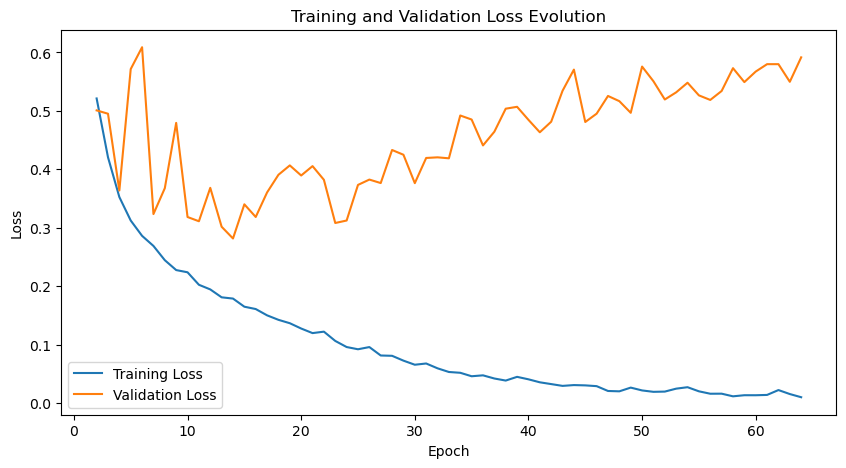

Cross-Entropy on training set:  0.0102
Accuracy on training set:       99.60%

Cross-Entropy on validation set: 0.5916
Accuracy on validation set:      91.10%


In [8]:
# Train the network
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ResNet18, TrainLoader, TestLoader, optimizer, criterion, epochs = 64, device = device)

### Exercise 1 (C) iii)

In [9]:
# Use a ResNet-18 with pre-trained weights
ResNet18_pretrained = resnet18(weights = ResNet18_Weights.DEFAULT)

# Adapt the ResNet-18 pre-trained to the FashionMNIST dataset
ResNet18_pretrained.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
ResNet18_pretrained.fc = torch.nn.Linear(ResNet18_pretrained.fc.in_features, 10)

In [10]:
# Initialize the network, loss function, and optimizer
device = set_device()
ResNet18_pretrained = ResNet18_pretrained.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18_pretrained.parameters(), lr = 0.01)

Device: mps


Epoch 1/64
======== Training phase ========


Loss = 1.0555  |  Accuracy = 32.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 1.8937
Training Accuracy = 32.47%
======== Validation phase ========


Loss = 7.9639  |  Accuracy = 28.45% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


Validation Cross-Entropy Loss = 7.9807
Validation Accuracy = 28.45%

Epoch 2/64
======== Training phase ========


Loss = 0.6603  |  Accuracy = 68.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.8098
Training Accuracy = 68.92%
======== Validation phase ========


Loss = 2.1906  |  Accuracy = 54.67% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 2.0304
Validation Accuracy = 54.67%

Epoch 3/64
======== Training phase ========


Loss = 0.5140  |  Accuracy = 80.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.5362
Training Accuracy = 80.16%
======== Validation phase ========


Loss = 0.6306  |  Accuracy = 76.16% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.6207
Validation Accuracy = 76.16%

Epoch 4/64
======== Training phase ========


Loss = 0.4765  |  Accuracy = 83.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.4477
Training Accuracy = 83.53%
======== Validation phase ========


Loss = 0.9933  |  Accuracy = 64.48% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 1.0244
Validation Accuracy = 64.48%

Epoch 5/64
======== Training phase ========


Loss = 0.4394  |  Accuracy = 86.13% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.3804
Training Accuracy = 86.13%
======== Validation phase ========


Loss = 0.4479  |  Accuracy = 83.49% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.4530
Validation Accuracy = 83.49%

Epoch 6/64
======== Training phase ========


Loss = 0.3609  |  Accuracy = 87.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.3416
Training Accuracy = 87.45%
======== Validation phase ========


Loss = 0.4880  |  Accuracy = 81.31% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.4916
Validation Accuracy = 81.31%

Epoch 7/64
======== Training phase ========


Loss = 0.2697  |  Accuracy = 88.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.3086
Training Accuracy = 88.64%
======== Validation phase ========


Loss = 0.3641  |  Accuracy = 86.85% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.3552
Validation Accuracy = 86.85%

Epoch 8/64
======== Training phase ========


Loss = 0.2771  |  Accuracy = 89.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.2918
Training Accuracy = 89.25%
======== Validation phase ========


Loss = 0.3419  |  Accuracy = 87.65% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.3448
Validation Accuracy = 87.65%

Epoch 9/64
======== Training phase ========


Loss = 0.3013  |  Accuracy = 89.94% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.2735
Training Accuracy = 89.94%
======== Validation phase ========


Loss = 0.3213  |  Accuracy = 87.94% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3283
Validation Accuracy = 87.94%

Epoch 10/64
======== Training phase ========


Loss = 0.2810  |  Accuracy = 90.35% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.2600
Training Accuracy = 90.35%
======== Validation phase ========


Loss = 0.3254  |  Accuracy = 88.16% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3247
Validation Accuracy = 88.16%

Epoch 11/64
======== Training phase ========


Loss = 0.2806  |  Accuracy = 90.67% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.2539
Training Accuracy = 90.67%
======== Validation phase ========


Loss = 0.3135  |  Accuracy = 88.38% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.3180
Validation Accuracy = 88.38%

Epoch 12/64
======== Training phase ========


Loss = 0.1890  |  Accuracy = 91.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.2272
Training Accuracy = 91.58%
======== Validation phase ========


Loss = 0.3284  |  Accuracy = 88.78% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3081
Validation Accuracy = 88.78%

Epoch 13/64
======== Training phase ========


Loss = 0.2449  |  Accuracy = 91.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.2193
Training Accuracy = 91.89%
======== Validation phase ========


Loss = 0.3719  |  Accuracy = 86.71% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Validation Cross-Entropy Loss = 0.3857
Validation Accuracy = 86.71%

Epoch 14/64
======== Training phase ========


Loss = 0.1948  |  Accuracy = 92.31% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.2063
Training Accuracy = 92.31%
======== Validation phase ========


Loss = 0.3103  |  Accuracy = 89.56% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


Validation Cross-Entropy Loss = 0.3005
Validation Accuracy = 89.56%

Epoch 15/64
======== Training phase ========


Loss = 0.2177  |  Accuracy = 92.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.1991
Training Accuracy = 92.68%
======== Validation phase ========


Loss = 0.3717  |  Accuracy = 87.66% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.3642
Validation Accuracy = 87.66%

Epoch 16/64
======== Training phase ========


Loss = 0.2037  |  Accuracy = 92.83% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.1921
Training Accuracy = 92.83%
======== Validation phase ========


Loss = 0.3209  |  Accuracy = 88.72% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.3260
Validation Accuracy = 88.72%

Epoch 17/64
======== Training phase ========


Loss = 0.1814  |  Accuracy = 93.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.1807
Training Accuracy = 93.20%
======== Validation phase ========


Loss = 0.3717  |  Accuracy = 88.04% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.3702
Validation Accuracy = 88.04%

Epoch 18/64
======== Training phase ========


Loss = 0.1882  |  Accuracy = 93.65% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.1723
Training Accuracy = 93.65%
======== Validation phase ========


Loss = 0.2844  |  Accuracy = 90.35% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


Validation Cross-Entropy Loss = 0.2882
Validation Accuracy = 90.35%

Epoch 19/64
======== Training phase ========


Loss = 0.1466  |  Accuracy = 93.88% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.1628
Training Accuracy = 93.88%
======== Validation phase ========


Loss = 0.3269  |  Accuracy = 89.75% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


Validation Cross-Entropy Loss = 0.3106
Validation Accuracy = 89.75%

Epoch 20/64
======== Training phase ========


Loss = 0.1733  |  Accuracy = 94.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.1504
Training Accuracy = 94.38%
======== Validation phase ========


Loss = 0.3223  |  Accuracy = 89.13% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3221
Validation Accuracy = 89.13%

Epoch 21/64
======== Training phase ========


Loss = 0.1760  |  Accuracy = 94.18% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.1530
Training Accuracy = 94.18%
======== Validation phase ========


Loss = 0.2933  |  Accuracy = 90.02% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.2907
Validation Accuracy = 90.02%

Epoch 22/64
======== Training phase ========


Loss = 0.1213  |  Accuracy = 94.82% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.1370
Training Accuracy = 94.82%
======== Validation phase ========


Loss = 0.3423  |  Accuracy = 88.83% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.3481
Validation Accuracy = 88.83%

Epoch 23/64
======== Training phase ========


Loss = 0.1598  |  Accuracy = 94.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.1374
Training Accuracy = 94.80%
======== Validation phase ========


Loss = 0.3244  |  Accuracy = 89.63% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


Validation Cross-Entropy Loss = 0.3145
Validation Accuracy = 89.63%

Epoch 24/64
======== Training phase ========


Loss = 0.1228  |  Accuracy = 95.14% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.1306
Training Accuracy = 95.14%
======== Validation phase ========


Loss = 0.2958  |  Accuracy = 90.49% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.2897
Validation Accuracy = 90.49%

Epoch 25/64
======== Training phase ========


Loss = 0.1149  |  Accuracy = 95.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.1097
Training Accuracy = 95.89%
======== Validation phase ========


Loss = 0.3286  |  Accuracy = 90.39% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3161
Validation Accuracy = 90.39%

Epoch 26/64
======== Training phase ========


Loss = 0.1231  |  Accuracy = 96.15% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.1043
Training Accuracy = 96.15%
======== Validation phase ========


Loss = 0.3343  |  Accuracy = 90.91% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.3276
Validation Accuracy = 90.91%

Epoch 27/64
======== Training phase ========


Loss = 0.1478  |  Accuracy = 96.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.1038
Training Accuracy = 96.25%
======== Validation phase ========


Loss = 0.6333  |  Accuracy = 84.47% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.6042
Validation Accuracy = 84.47%

Epoch 28/64
======== Training phase ========


Loss = 0.1053  |  Accuracy = 95.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.1103
Training Accuracy = 95.87%
======== Validation phase ========


Loss = 0.3717  |  Accuracy = 88.17% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3922
Validation Accuracy = 88.17%

Epoch 29/64
======== Training phase ========


Loss = 0.1431  |  Accuracy = 96.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.1042
Training Accuracy = 96.11%
======== Validation phase ========


Loss = 0.3546  |  Accuracy = 90.24% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.3314
Validation Accuracy = 90.24%

Epoch 30/64
======== Training phase ========


Loss = 0.1097  |  Accuracy = 97.10% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0810
Training Accuracy = 97.10%
======== Validation phase ========


Loss = 0.3187  |  Accuracy = 90.72% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.3201
Validation Accuracy = 90.72%

Epoch 31/64
======== Training phase ========


Loss = 0.0929  |  Accuracy = 97.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0767
Training Accuracy = 97.16%
======== Validation phase ========


Loss = 0.3541  |  Accuracy = 90.78% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.3396
Validation Accuracy = 90.78%

Epoch 32/64
======== Training phase ========


Loss = 0.0902  |  Accuracy = 97.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0695
Training Accuracy = 97.44%
======== Validation phase ========


Loss = 0.4099  |  Accuracy = 89.70% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.3963
Validation Accuracy = 89.70%

Epoch 33/64
======== Training phase ========


Loss = 0.0662  |  Accuracy = 97.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0652
Training Accuracy = 97.64%
======== Validation phase ========


Loss = 0.3924  |  Accuracy = 90.60% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3731
Validation Accuracy = 90.60%

Epoch 34/64
======== Training phase ========


Loss = 0.0780  |  Accuracy = 97.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0644
Training Accuracy = 97.58%
======== Validation phase ========


Loss = 0.3642  |  Accuracy = 90.86% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.3827
Validation Accuracy = 90.86%

Epoch 35/64
======== Training phase ========


Loss = 0.0466  |  Accuracy = 98.06% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0535
Training Accuracy = 98.06%
======== Validation phase ========


Loss = 0.4910  |  Accuracy = 90.28% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


Validation Cross-Entropy Loss = 0.4325
Validation Accuracy = 90.28%

Epoch 36/64
======== Training phase ========


Loss = 0.0549  |  Accuracy = 97.74% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0604
Training Accuracy = 97.74%
======== Validation phase ========


Loss = 0.4581  |  Accuracy = 89.91% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


Validation Cross-Entropy Loss = 0.4081
Validation Accuracy = 89.91%

Epoch 37/64
======== Training phase ========


Loss = 0.0616  |  Accuracy = 98.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.0484
Training Accuracy = 98.25%
======== Validation phase ========


Loss = 0.4471  |  Accuracy = 89.84% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.4251
Validation Accuracy = 89.84%

Epoch 38/64
======== Training phase ========


Loss = 0.0625  |  Accuracy = 98.20% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0499
Training Accuracy = 98.20%
======== Validation phase ========


Loss = 0.4376  |  Accuracy = 90.48% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.4090
Validation Accuracy = 90.48%

Epoch 39/64
======== Training phase ========


Loss = 0.0631  |  Accuracy = 98.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0454
Training Accuracy = 98.38%
======== Validation phase ========


Loss = 0.4484  |  Accuracy = 90.38% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.4288
Validation Accuracy = 90.38%

Epoch 40/64
======== Training phase ========


Loss = 0.0636  |  Accuracy = 98.36% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0447
Training Accuracy = 98.36%
======== Validation phase ========


Loss = 0.4965  |  Accuracy = 89.49% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.5028
Validation Accuracy = 89.49%

Epoch 41/64
======== Training phase ========


Loss = 0.0234  |  Accuracy = 98.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0476
Training Accuracy = 98.19%
======== Validation phase ========


Loss = 0.4352  |  Accuracy = 90.85% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.4254
Validation Accuracy = 90.85%

Epoch 42/64
======== Training phase ========


Loss = 0.0584  |  Accuracy = 98.64% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0391
Training Accuracy = 98.64%
======== Validation phase ========


Loss = 0.4181  |  Accuracy = 90.83% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.4083
Validation Accuracy = 90.83%

Epoch 43/64
======== Training phase ========


Loss = 0.0345  |  Accuracy = 98.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0299
Training Accuracy = 98.92%
======== Validation phase ========


Loss = 0.5384  |  Accuracy = 89.91% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.4999
Validation Accuracy = 89.91%

Epoch 44/64
======== Training phase ========


Loss = 0.0380  |  Accuracy = 98.81% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.0323
Training Accuracy = 98.81%
======== Validation phase ========


Loss = 0.4733  |  Accuracy = 89.95% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.4786
Validation Accuracy = 89.95%

Epoch 45/64
======== Training phase ========


Loss = 0.0550  |  Accuracy = 98.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Training Cross-Entropy Loss = 0.0330
Training Accuracy = 98.80%
======== Validation phase ========


Loss = 0.4900  |  Accuracy = 90.69% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.4907
Validation Accuracy = 90.69%

Epoch 46/64
======== Training phase ========


Loss = 0.0351  |  Accuracy = 98.77% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0341
Training Accuracy = 98.77%
======== Validation phase ========


Loss = 0.4801  |  Accuracy = 91.02% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.4751
Validation Accuracy = 91.02%

Epoch 47/64
======== Training phase ========


Loss = 0.0310  |  Accuracy = 98.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0302
Training Accuracy = 98.89%
======== Validation phase ========


Loss = 0.4286  |  Accuracy = 90.64% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Validation Cross-Entropy Loss = 0.4548
Validation Accuracy = 90.64%

Epoch 48/64
======== Training phase ========


Loss = 0.0174  |  Accuracy = 98.90% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0302
Training Accuracy = 98.90%
======== Validation phase ========


Loss = 0.4859  |  Accuracy = 90.87% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Validation Cross-Entropy Loss = 0.4731
Validation Accuracy = 90.87%

Epoch 49/64
======== Training phase ========


Loss = 0.0510  |  Accuracy = 99.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0213
Training Accuracy = 99.25%
======== Validation phase ========


Loss = 0.5240  |  Accuracy = 90.22% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


Validation Cross-Entropy Loss = 0.5563
Validation Accuracy = 90.22%

Epoch 50/64
======== Training phase ========


Loss = 0.0325  |  Accuracy = 98.70% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0362
Training Accuracy = 98.70%
======== Validation phase ========


Loss = 0.4469  |  Accuracy = 90.33% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


Validation Cross-Entropy Loss = 0.4388
Validation Accuracy = 90.33%

Epoch 51/64
======== Training phase ========


Loss = 0.0236  |  Accuracy = 99.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Training Cross-Entropy Loss = 0.0218
Training Accuracy = 99.25%
======== Validation phase ========


Loss = 0.5310  |  Accuracy = 90.44% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.5246
Validation Accuracy = 90.44%

Epoch 52/64
======== Training phase ========


Loss = 0.0788  |  Accuracy = 99.11% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Training Cross-Entropy Loss = 0.0257
Training Accuracy = 99.11%
======== Validation phase ========


Loss = 0.4558  |  Accuracy = 90.71% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.4733
Validation Accuracy = 90.71%

Epoch 53/64
======== Training phase ========


Loss = 0.0482  |  Accuracy = 98.47% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0439
Training Accuracy = 98.47%
======== Validation phase ========


Loss = 0.4254  |  Accuracy = 90.77% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Validation Cross-Entropy Loss = 0.4432
Validation Accuracy = 90.77%

Epoch 54/64
======== Training phase ========


Loss = 0.0171  |  Accuracy = 98.66% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Training Cross-Entropy Loss = 0.0368
Training Accuracy = 98.66%
======== Validation phase ========


Loss = 0.4792  |  Accuracy = 90.09% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Validation Cross-Entropy Loss = 0.4932
Validation Accuracy = 90.09%

Epoch 55/64
======== Training phase ========


Loss = 0.0260  |  Accuracy = 99.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:20<00:00,  1.45it/s]


Training Cross-Entropy Loss = 0.0214
Training Accuracy = 99.27%
======== Validation phase ========


Loss = 0.4700  |  Accuracy = 90.67% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Validation Cross-Entropy Loss = 0.4778
Validation Accuracy = 90.67%

Epoch 56/64
======== Training phase ========


Loss = 0.0156  |  Accuracy = 99.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


Training Cross-Entropy Loss = 0.0215
Training Accuracy = 99.27%
======== Validation phase ========


Loss = 0.4858  |  Accuracy = 91.19% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


Validation Cross-Entropy Loss = 0.4817
Validation Accuracy = 91.19%

Epoch 57/64
======== Training phase ========


Loss = 0.0172  |  Accuracy = 99.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


Training Cross-Entropy Loss = 0.0155
Training Accuracy = 99.44%
======== Validation phase ========


Loss = 0.5097  |  Accuracy = 90.90% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


Validation Cross-Entropy Loss = 0.5184
Validation Accuracy = 90.90%

Epoch 58/64
======== Training phase ========


Loss = 0.0088  |  Accuracy = 99.56% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


Training Cross-Entropy Loss = 0.0133
Training Accuracy = 99.56%
======== Validation phase ========


Loss = 0.5677  |  Accuracy = 90.61% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


Validation Cross-Entropy Loss = 0.5818
Validation Accuracy = 90.61%

Epoch 59/64
======== Training phase ========


Loss = 0.0174  |  Accuracy = 99.43% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.04it/s]


Training Cross-Entropy Loss = 0.0163
Training Accuracy = 99.43%
======== Validation phase ========


Loss = 0.5671  |  Accuracy = 90.69% | Batch ID = 5 : 100%|██████████| 5/5 [15:26<00:00, 185.38s/it]  


Validation Cross-Entropy Loss = 0.5528
Validation Accuracy = 90.69%

Epoch 60/64
======== Training phase ========


Loss = 0.0159  |  Accuracy = 99.24% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.08it/s]


Training Cross-Entropy Loss = 0.0212
Training Accuracy = 99.24%
======== Validation phase ========


Loss = 0.4870  |  Accuracy = 90.23% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]


Validation Cross-Entropy Loss = 0.5134
Validation Accuracy = 90.23%

Epoch 61/64
======== Training phase ========


Loss = 0.0153  |  Accuracy = 99.37% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


Training Cross-Entropy Loss = 0.0193
Training Accuracy = 99.37%
======== Validation phase ========


Loss = 0.5478  |  Accuracy = 90.94% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Validation Cross-Entropy Loss = 0.5241
Validation Accuracy = 90.94%

Epoch 62/64
======== Training phase ========


Loss = 0.0126  |  Accuracy = 99.44% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.08it/s]


Training Cross-Entropy Loss = 0.0157
Training Accuracy = 99.44%
======== Validation phase ========


Loss = 0.5626  |  Accuracy = 90.80% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


Validation Cross-Entropy Loss = 0.5567
Validation Accuracy = 90.80%

Epoch 63/64
======== Training phase ========


Loss = 0.0049  |  Accuracy = 99.45% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


Training Cross-Entropy Loss = 0.0160
Training Accuracy = 99.45%
======== Validation phase ========


Loss = 0.4942  |  Accuracy = 90.74% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


Validation Cross-Entropy Loss = 0.5058
Validation Accuracy = 90.74%

Epoch 64/64
======== Training phase ========


Loss = 0.0146  |  Accuracy = 99.51% | Batch ID = 30 : 100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


Training Cross-Entropy Loss = 0.0139
Training Accuracy = 99.51%
======== Validation phase ========


Loss = 0.6023  |  Accuracy = 90.46% | Batch ID = 5 : 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


Validation Cross-Entropy Loss = 0.5677
Validation Accuracy = 90.46%



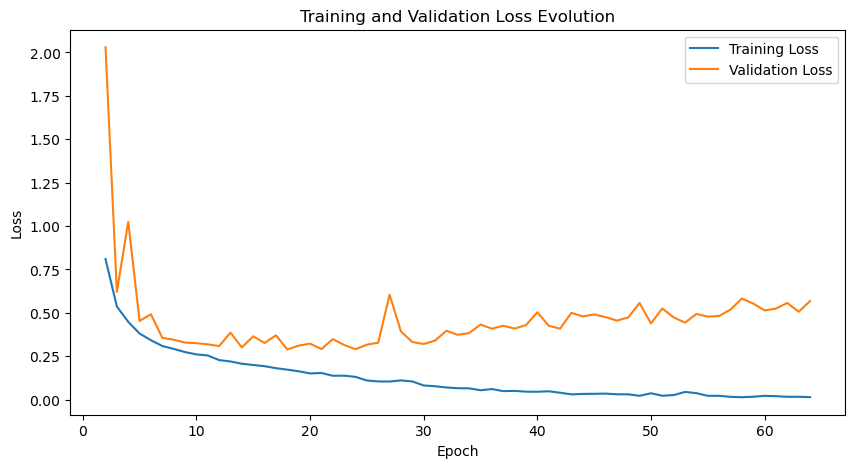

Cross-Entropy on training set:  0.0139
Accuracy on training set:       99.51%

Cross-Entropy on validation set: 0.5677
Accuracy on validation set:      90.46%


In [11]:
# Train the network
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(ResNet18_pretrained, TrainLoader, TestLoader, optimizer, criterion, epochs = 64, device = device)